In [1]:
import os, sys

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3 as pm # for uncertainty quantification and model calibration
from scipy.integrate import solve_ivp # to solve ODE system
from scipy import optimize # to solve minimization problem from least-squares fitting
from numba import jit # to accelerate ODE system RHS evaluations
import theano # to control better pymc3 backend and write a wrapper
import theano.tensor as t # for the wrapper to a custom model to pymc3
import arviz as az
# Plotting libs
import matplotlib.pyplot as plt
import altair as alt

import corner
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from pymc3.distributions.dist_math import normal_lcdf

seed = 12345 # for the sake of reproducibility :)
np.random.seed(seed)

plt.style.use('seaborn-talk') # beautify the plots!

THEANO_FLAGS='optimizer=fast_compile' # A theano trick

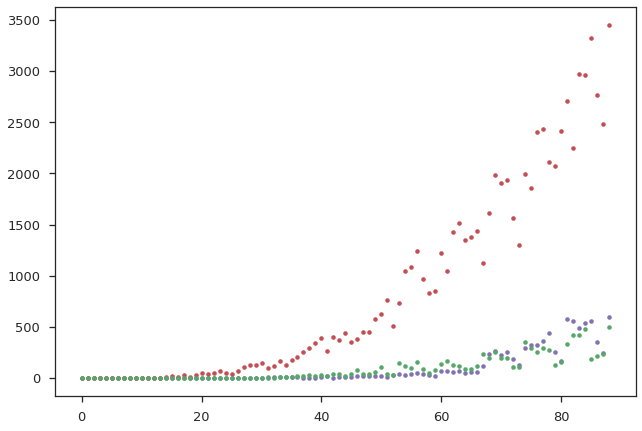

In [9]:
TotalNumIter = 4000
NumProc      = 2
NumEqs       = 7
NumParams    = 10

# pesos para la cuadratura trapezoidal
weigths = np.ones(11)
weigths[0] = 0.5
weigths[-1] = 0.5


data=pd.read_csv("Data/covidMexico.csv")
yobs=data[["Suspects","New cases (HUC)","Deaths (HUC)"]]
y_obs_temp=yobs.to_numpy()

y_obs=y_obs_temp.astype(float)
   
muM    = 0.0171361/365
nu    = 0.0058/365
#   tau_A = 1/14 # period of being active: 14 days
k_conts     = 500/365 # number of contacts per year
tau_Q =1/14  #(1/tau_Q := period of quarantined) 
rho  =1/15    
N     = 128932753

# Initial conditions

R0 = 0
P0 = 0


#save_results_to = 'MODEL_PRED/'
  
# # HUC
Suspect = data["Suspects"]
Sick = data["New cases (HUC)"]
Deaths  = data["Deaths (HUC)"] 

# datahub
# Sick = data["New cases (datahub)"]
# Deaths  = data["Deaths (datahub)"] 

## OWD
#Sick = data["New cases (OWD)"]
#Deaths  = data["Deaths (OWD)"] + data["Recovered (noData)"]

# # DGE
# Sick = data["New cases (DGE)"]
# Deaths  = data["Deaths (DGE)"] 

#ttime = np.linspace(0.0,float(len(Sick)),len(Sick))
#ttime = list(float(i) for i in range(len(Sick)))
ttime = np.array([float(i)  for i in range( len(Sick) )])
t_pred = np.array([float(i) for i in range( 120 )])

fig0= plt.figure()
plt.plot(ttime, Suspect,'m.', ttime, Sick,'r.',ttime, Deaths,'g.')
#plt.show()
plt.savefig( 'Suspects_NewCases_Deaths.eps')

In [10]:
@jit(nopython=True)
def modelo(t,y,p):
    
  """
  model:SsEIQRP
  
  Parameters:
  p[0]: beta factor b
  p[1]: qu contact tracing rate
  p[2]: delta Detection and isolation rate
  p[3]: alpha transmision rate from E to I
  p[4]: gamma recovery rate
  p[5]: sigma death rate by disease 
  
  State variables: SsEIQRP
  
  x[0]: Susceptibles
  x[1]: suspects
  x[2]: Exposeds
  x[3]: Infecteds
  x[4]: Quarainteds
  x[5]: Recovereds
  x[6]: Deaths
  """
  
  dS = muM*N -(k_conts*p[0]*y[3] + p[1]*k_conts*(1- p[0])*y[3]   )*y[0]/N \
         + tau_Q*y[1] - nu*y[0]
  ds =  p[1]*k_conts*(1- p[0])*y[3] *y[0]/N - (tau_Q + nu)*y[1]
  dE =  k_conts*p[0]*(1- p[1])*y[3] *y[0]/N - (p[3] + nu)*y[2] 
  dI =  p[3]*y[2] - ( p[5] + p[2] + nu  )* y[3]
  dQ =  p[1]* k_conts* p[0]*y[3] *y[0]/N + p[2]*y[3] - (tau_Q + p[5]  )*y[4]
  dR = p[4]*y[3] + tau_Q*y[4]
  dP = p[5]*y[4]
  

  return dS,ds,dE,dI,dQ,dR,dP

In [11]:
def seir_ode_solver(y0, t_span, t_eval, p):

    solution_ODE = solve_ivp(
        fun=lambda t, y: modelo(t, y, p), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE

In [12]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dmatrix,t.dvector], otypes=[t.dmatrix])
def seir_ode_solver_wrapper(time_exp, Obs_s,p):

    time_span = (time_exp.min(), time_exp.max())
    initial_conditions=x0 = np.array([N-(p[6] + p[7] + p[8] + p[9] + R0 + P0),p[6],p[7]
                   ,p[8],p[9],R0,P0]) # SsEIQRP                             
                             
    y_model = seir_ode_solver(initial_conditions, time_span, time_exp, p)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, x_s, _, _, x_Q, _, x_P = simulated_ode_solution

    return np.array([x_s,x_Q,x_P]).T

In [13]:
with pm.Model() as model_CT:

#   Prior distributions for the model's parameters
    # Beta  =pm.Bound(pm.Gamma, lower=0., upper=6.)('Beta', alpha=2.5, beta=1.0)
    # qu    =pm.Bound(pm.Gamma, lower=0., upper=4.)('qu',   alpha=2.5, beta=1.0)
    # delta =pm.Bound(pm.Gamma, lower=0., upper=5.)('delta', alpha=2.5, beta=1.0)
    # alfa  =pm.Bound(pm.Gamma, lower=0., upper=5.)('alfa', alpha=3.0, beta=1.0)
    # gama  =pm.Bound(pm.Gamma, lower=0., upper=5.)('gama', alpha=2.5, beta=1.0)
    # sigm = pm.Bound(pm.Gamma, lower=0., upper=3.)('sigm', alpha=2.5, beta=1.0)
    # s0    =pm.Bound(pm.Gamma, lower=0., upper=1e3)('s0', alpha=10, beta=1.0)
    # E0    =pm.Bound(pm.Gamma, lower=0., upper=1e4)('E0', alpha=10, beta=1.0)
    # I0    =pm.Bound(pm.Gamma, lower=0., upper=1e4)('I0', alpha=10, beta=1.0)
    # Q0    =pm.Bound(pm.Gamma, lower=0., upper=1e3)('Q0', alpha=10, beta=1.0)

    Beta   = pm.Lognormal('Beta', mu=0, sigma=1.5)
#   Beta   = pm.Uniform('Beta', lower=0, upper=2.0)
    qu     = pm.Uniform('qu'  , lower=0, upper=2.0)
    delta  = pm.Uniform('delta'  , lower=0, upper=2.0)
    alfa   = pm.Uniform('alfa'  , lower=0, upper=2.0)
    gama   = pm.Uniform('gama'  , lower=0, upper=2.0)
    sigm   = pm.Uniform('sigm'  , lower=0, upper=2.0)
    s0     = pm.Uniform('s0'  , lower=0, upper=1e3)
    E0     = pm.Uniform('E0'  , lower=0, upper=1e4)
    I0     = pm.Uniform('I0'  , lower=0, upper=1e4)
    Q0     = pm.Uniform('Q0'  , lower=0, upper=1e3)

    sigmaH = pm.HalfCauchy('sigmaH',1)
#   print(type(Beta))

#   p=np.array([Beta,qu,delta,alfa,gama,sigm,s0,E0,I0,Q0]).T
#   p=[Beta,qu,delta,alfa,gama,sigm,s0,E0,I0,Q0]
#   p =t.stack([Beta,qu,delta,alfa,gama,sigm,s0,E0,I0,Q0])
#   p = pm.math.stack(([[Beta],[qu],[delta],[alfa],[gama],[sigm],[s0],[E0],[I0],[Q0]]))
    p = t.transpose(pm.math.stack((Beta,qu,delta,alfa,gama,sigm,s0,E0,I0,Q0)))

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic('modelo', seir_ode_solver_wrapper(
        theano.shared(ttime),
        theano.shared(y_obs), 
        p
        )
    )


    Y = pm.Normal('Y' , mu=fitting_model, sigma=sigmaH, observed=y_obs)
#   Y = pm.Poisson('Y', mu=fitting_model,  observed=y_obs)
#   Y = pm.NegativeBinomial('Y',mu=fitting_model, alpha=sigmaH,observed=yobs)

    # The Monte Carlo procedure driver
    step = pm.step_methods.Metropolis()
#   seir_trace = pm.sample(2000, chains=4, cores=2, step=step)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(TotalNumIter,tune=1000,init='adapt_diag', cores=NumProc,step=step)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)
varnames = ["Beta", "qu","delta","alfa","gama","sigm","s0","E0","I0","Q0","sigmaH"]
pm.summary(trace, var_names=varnames,hdi_prob=0.95)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigmaH]
>Metropolis: [Q0]
>Metropolis: [I0]
>Metropolis: [E0]
>Metropolis: [s0]
>Metropolis: [sigm]
>Metropolis: [gama]
>Metropolis: [alfa]
>Metropolis: [delta]
>Metropolis: [qu]
>Metropolis: [Beta]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 258 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/david/anaconda3/envs/DifferentialEquations/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Beta,1.867,0.987,0.864,2.999,0.695,0.588,2.0,2.0,3.0,28.0,1.84
qu,0.398,0.398,0.000,0.810,0.281,0.238,2.0,2.0,3.0,11.0,1.87
delta,0.071,0.054,0.010,0.133,0.038,0.032,2.0,2.0,3.0,14.0,2.12
alfa,0.009,0.007,0.002,0.016,0.005,0.004,2.0,2.0,3.0,12.0,2.02
gama,0.987,0.572,0.000,1.886,0.013,0.009,1827.0,1827.0,1721.0,1552.0,1.00
sigm,0.005,0.001,0.004,0.006,0.000,0.000,133.0,120.0,138.0,74.0,1.05
s0,39.642,33.418,0.027,106.442,8.054,5.794,17.0,17.0,22.0,955.0,1.08
E0,4157.356,4158.715,0.119,8918.832,2928.383,2477.091,2.0,2.0,3.0,42.0,1.98
I0,14.880,8.893,0.026,33.925,0.859,0.617,107.0,105.0,98.0,151.0,1.35
Q0,18.734,18.841,0.070,55.990,3.609,2.579,27.0,27.0,23.0,1617.0,1.06
